In [3]:
import os

import numpy as np

import pandas as pd

from PIL import Image

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf

from tensorflow.keras import layers, models

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [4]:
# Dataset already available in archive folder

download_path = "archive"

print("Using dataset from:", os.path.abspath(download_path))

Using dataset from: d:\CDAC\Deep Learning\archive


In [5]:
DATA_PATH = "archive"  # Update with your path
CSV_PATH = f"{DATA_PATH}/Train.csv"
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
EPOCHS = 15
FINE_TUNE_EPOCHS = 8
SEED = 42
NUM_CLASSES = 43

In [6]:
meta = pd.read_csv(CSV_PATH)
meta['full_path'] = meta['Path'].apply(lambda x: os.path.join(DATA_PATH, x))

X = []
y = []

for i, row in meta.iterrows():
    img = Image.open(row['full_path']).convert('RGB')
    img = img.resize(IMG_SIZE)
    X.append(np.array(img))
    y.append(row['ClassId'])

X = np.array(X)
y = np.array(y)

print("Loaded:", X.shape, y.shape)

Loaded: (39209, 64, 64, 3) (39209,)


In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print("Train/Val/Test:", X_train.shape, X_val.shape, X_test.shape)

Train/Val/Test: (31367, 64, 64, 3) (3921, 64, 64, 3) (3921, 64, 64, 3)


In [12]:
augment = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.15, 0.15),
    layers.RandomContrast(0.3),
])

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(images, labels, train=False):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if train:
        ds = ds.shuffle(len(images))
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y), AUTOTUNE)
    if train:
        ds = ds.map(lambda x, y: (augment(x, training=True), y), AUTOTUNE)
    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(X_train, y_train, train=True)
val_ds = make_ds(X_val, y_val)
test_ds = make_ds(X_test, y_test)


In [21]:
model = models.Sequential([
    layers.Input(shape=(32,32,3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 376,907 (1.44 MB)

 Trainable params: 376,011 (1.43 MB)

 Non-trainable params: 896 (3.50 KB)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)


In [23]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

In [24]:
IMG_SIZE = (64, 64)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 236s 468ms/step - accuracy: 0.3101 - loss: 2.3658 - val_accuracy: 0.2811 - val_loss: 2.5613 - learning_rate: 0.0010
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 236s 480ms/step - accuracy: 0.7141 - loss: 0.8975 - val_accuracy: 0.8324 - val_loss: 0.5427 - learning_rate: 0.0010
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 331s 675ms/step - accuracy: 0.8982 - loss: 0.3273 - val_accuracy: 0.9500 - val_loss: 0.1648 - learning_rate: 0.0010
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 516s 1s/step - accuracy: 0.9482 - loss: 0.1722 - val_accuracy: 0.9651 - val_loss: 0.1105 - learning_rate: 0.0010
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 313s 638ms/step - accuracy: 0.9628 - loss: 0.1218 - val_accuracy: 0.9908 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 251s 510ms/step - accuracy: 0.9728 - loss: 0.0887 - val_accuracy: 0.9704 - val_loss: 0.0974 - learning_rate: 0.0010
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 275s 560ms/step - accuracy:

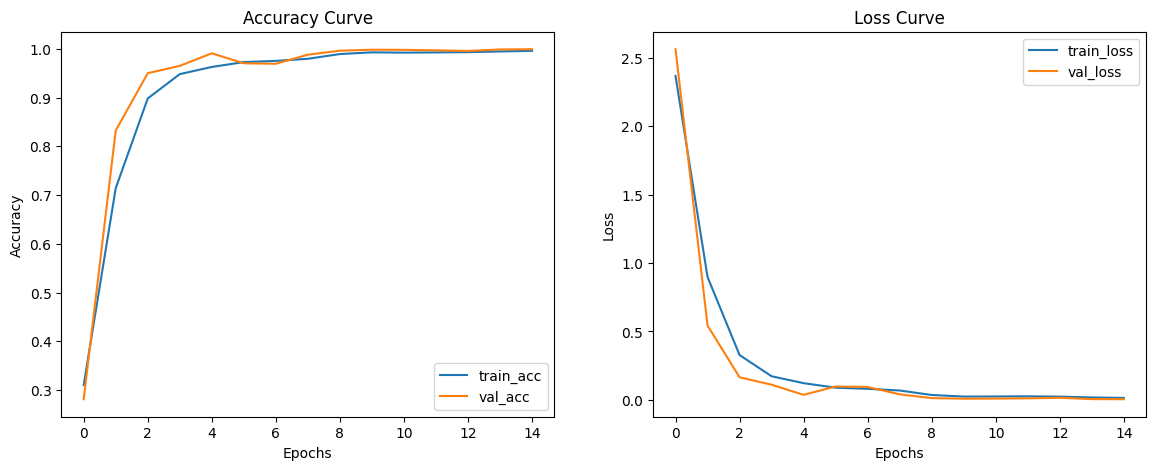

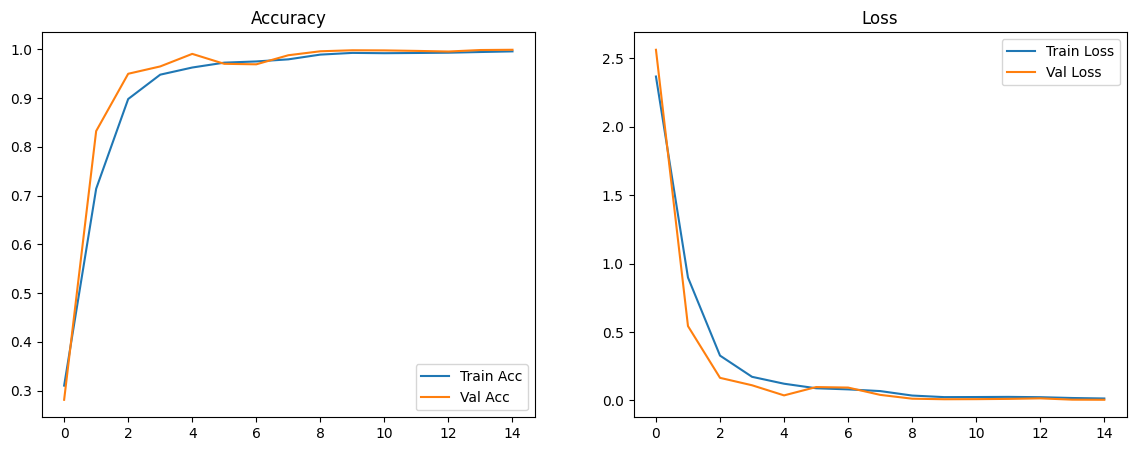

In [44]:
plt.figure(figsize=(14,5))


# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label="val_acc")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="train_loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


plt.show()
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title('Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

In [26]:
loss, acc = model.evaluate(test_ds)
print(f"Test Accuracy: {acc:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.9982 - loss: 0.0080
Test Accuracy: 0.9982


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step


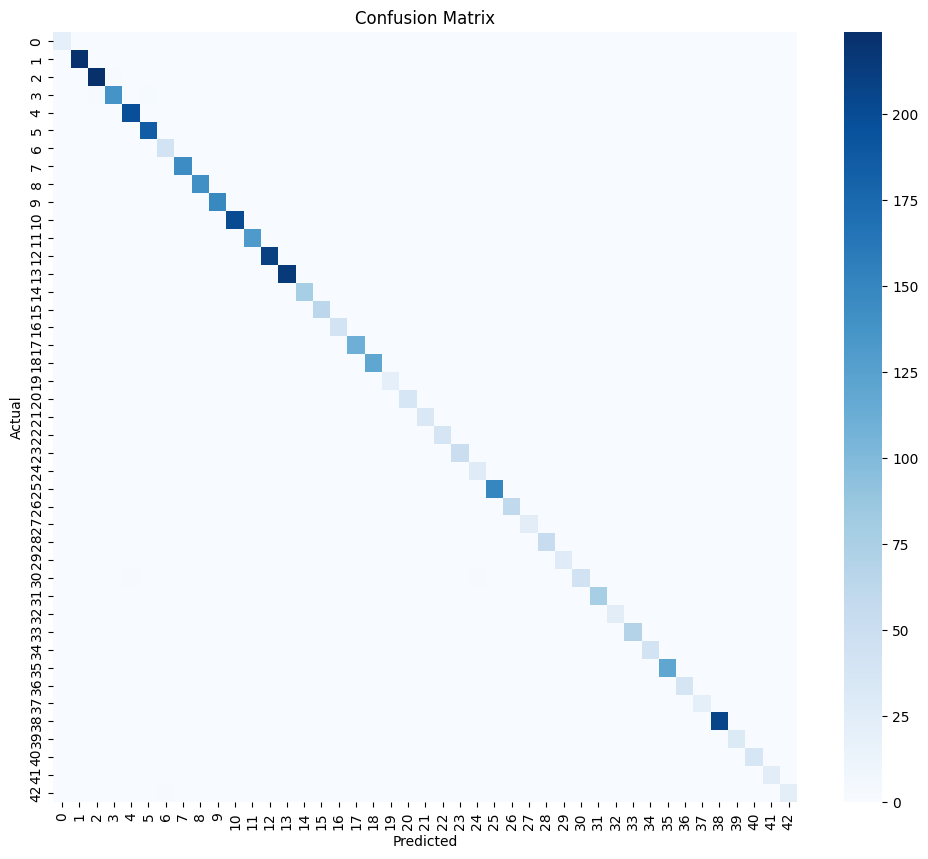

In [27]:
y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       225
           3       0.99      0.98      0.99       141
           4       0.99      1.00      1.00       198
           5       0.99      1.00      0.99       186
           6       0.98      1.00      0.99        42
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       141
           9       1.00      1.00      1.00       147
          10       1.00      1.00      1.00       201
          11       1.00      1.00      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
          17       1.00    

In [29]:
model.save("GTSRB_HighAccuracy_MobileNetV2.h5")
print("Model saved.")

Model saved.


In [32]:
from PIL import Image


def predict_single_image(model, path, img_size=(32,32)):
    img = Image.open(path).convert('RGB')
    img = img.resize(img_size)
    arr = np.array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)
    pred = model.predict(arr)
    cls = int(np.argmax(pred))
    conf = float(pred[0][cls])
    return cls, conf

In [34]:
def predict_train(model, train_ds):
    y_true = np.concatenate([y for _, y in train_ds])
    y_pred = np.argmax(model.predict(train_ds), axis=1)
    return y_true, y_pred

In [35]:
def predict_validation(model, val_ds):
    y_true = np.concatenate([y for _, y in val_ds])
    y_pred = np.argmax(model.predict(val_ds), axis=1)
    return y_true, y_pred

In [36]:
def predict_test(model, test_ds):
    y_true = np.concatenate([y for _, y in test_ds])
    y_pred = np.argmax(model.predict(test_ds), axis=1)
    return y_true, y_pred

In [37]:
def predict_folder(model, folder_path, img_size=(32,32)):
    results = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(("jpg","jpeg","png","ppm")):
           full = os.path.join(folder_path, file)
           cls, conf = predict_single_image(model, full, img_size)
           results.append((file, cls, conf))
    return results

print("Prediction functions added successfully.")

Prediction functions added successfully.


In [38]:
sample_path = meta['full_path'].iloc[0]
pred_class, pred_conf = predict_single_image(model, sample_path)
print(f"Single Image Prediction → Class: {pred_class}, Confidence: {pred_conf:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Single Image Prediction → Class: 13, Confidence: 0.3724


In [39]:
y_true_test, y_pred_test = predict_test(model, test_ds)
print("Test prediction completed.")

62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step
Test prediction completed.


In [45]:
sample_path = meta['full_path'].iloc[0]
pred_class, pred_conf = predict_single_image(model, sample_path)
print(f"Single Image Prediction → Class: {pred_class}, Confidence: {pred_conf:.4f}")


# Example 2: Predict entire test dataset
y_true_test, y_pred_test = predict_test(model, test_ds)
print("Test prediction completed.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Single Image Prediction → Class: 13, Confidence: 0.3724
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step
Test prediction completed.


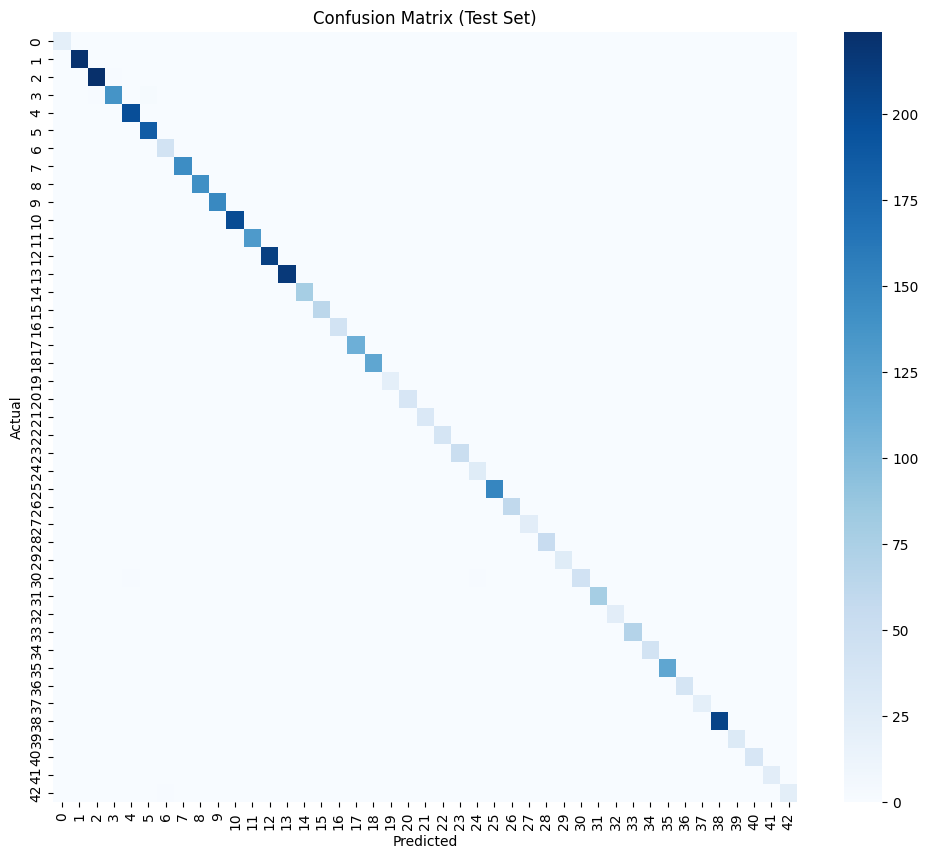

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00       222
           2       1.00      1.00      1.00       225
           3       0.99      0.98      0.99       141
           4       0.99      1.00      1.00       198
           5       0.99      1.00      0.99       186
           6       0.98      1.00      0.99        42
           7       1.00      1.00      1.00       144
           8       1.00      1.00      1.00       141
           9       1.00      1.00      1.00       147
          10       1.00      1.00      1.00       201
          11       1.00      1.00      1.00       132
          12       1.00      1.00      1.00       210
          13       1.00      1.00      1.00       216
          14       1.00      1.00      1.00        78
          15       1.00      1.00      1.00        63
          16       1.00      1.00      1.00        42
    

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Classification Report:")
print(classification_report(y_true_test, y_pred_test))

In [41]:
def visualize_prediction(model, path, img_size=(32,32)):
    img = Image.open(path).convert('RGB')
    img_resized = img.resize(img_size)
    arr = np.expand_dims(np.array(img_resized)/255.0, axis=0)
    pred = model.predict(arr)
    cls = np.argmax(pred)
    conf = float(pred[0][cls])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {cls} | Confidence: {conf:.3f}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


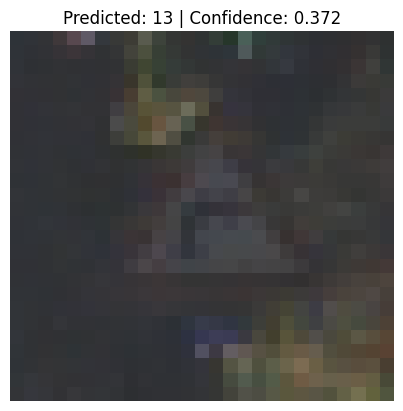

In [46]:
visualize_prediction(model, sample_path)

In [51]:
import cv2
import numpy as np

def predict_image_cv2(path, img_size=(32,32)):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    class_id = int(np.argmax(pred))
    confidence = float(pred[0][class_id])

    return class_id, confidence


In [55]:
predict_image_cv2("archive/Test/00000.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


(16, 0.9930817484855652)

In [ ]:
streamlit_code = r"""
import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('GTSRB_HighAccuracy_CNN.h5')

st.title("🚦 GTSRB Road Sign Recognition – Live Demo")
st.write("Upload a traffic sign image to classify it.")

uploaded = st.file_uploader("Upload Image", type=["jpg","jpeg","png","ppm"])

if uploaded:
   img = Image.open(uploaded).convert('RGB')
   st.image(img, caption="Uploaded Image", use_column_width=True)
   
   img_resized = img.resize((32,32))
   arr = np.expand_dims(np.array(img_resized)/255.0, axis=0)
   
   pred = model.predict(arr)
   cls = int(np.argmax(pred))
   conf = float(pred[0][cls])
   
   st.success(f"Predicted Class: {cls}")
   st.info(f"Confidence: {conf:.4f}")
"""

with open('streamlit_app.py', 'w', encoding='utf-8') as f:
    f.write(streamlit_code)

print("Streamlit app generated successfully → streamlit_app.py")

Streamlit app generated successfully → streamlit_app.py
